<a href="https://colab.research.google.com/github/san9roy/Signal-Processing-For-Space-Communications/blob/main/SiG_PROC_SP_COMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
Project: Signal Processing for Space Communication
--------------------------------------------------
Simulation of BPSK and QPSK transmission over an AWGN channel.
Performance is evaluated using BER vs Eb/N0 curves.

Key Features:
- Synthetic random bit generation (Monte Carlo method)
- BPSK and Gray-coded QPSK modulation
- AWGN channel model based on Eb/N0
- Hard-decision demodulation
- Theoretical BER comparison
- Optional constellation and eye diagram visualization

Assumptions:
- Unit average symbol energy (Es = 1)
- Coherent detection
- Ideal timing and carrier synchronization
"""

'\nProject: Signal Processing for Space Communication\n--------------------------------------------------\nSimulation of BPSK and QPSK transmission over an AWGN channel.\nPerformance is evaluated using BER vs Eb/N0 curves.\n\nKey Features:\n- Synthetic random bit generation (Monte Carlo method)\n- BPSK and Gray-coded QPSK modulation\n- AWGN channel model based on Eb/N0\n- Hard-decision demodulation\n- Theoretical BER comparison\n- Optional constellation and eye diagram visualization\n\nAssumptions:\n- Unit average symbol energy (Es = 1)\n- Coherent detection\n- Ideal timing and carrier synchronization\n'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import erfc


In [3]:
# ============================================================
# Utility Functions
# ============================================================

def q_function(x: np.ndarray) -> np.ndarray:
    """
    Gaussian Q-function:
        Q(x) = 0.5 * erfc(x / sqrt(2))

    Used to compute theoretical BER for coherent BPSK/QPSK in AWGN.
    """
    return 0.5 * np.vectorize(erfc)(x / np.sqrt(2))


def add_awgn_by_ebn0(tx, ebn0_db: float, bits_per_symbol: int, rng: np.random.Generator):
    """
    Adds Additive White Gaussian Noise (AWGN) based on a specified Eb/N0 value.

    Parameters:
    - tx: transmitted baseband signal (real or complex)
    - ebn0_db: Eb/N0 value in dB
    - bits_per_symbol: number of bits per symbol (1 for BPSK, 2 for QPSK)
    - rng: random number generator

    Assumptions:
    - Average symbol energy Es = 1
    - Eb = Es / bits_per_symbol
    - N0 = Eb / (Eb/N0)

    For complex signals:
        Noise variance per dimension = N0 / 2
    For real signals:
        Noise variance = N0 / 2
    """

    ebn0_linear = 10 ** (ebn0_db / 10)

    Es = 1.0
    Eb = Es / bits_per_symbol
    N0 = Eb / ebn0_linear

    if np.iscomplexobj(tx):
        sigma2 = N0 / 2
        noise = np.sqrt(sigma2) * (
            rng.standard_normal(tx.shape) +
            1j * rng.standard_normal(tx.shape)
        )
    else:
        sigma2 = N0 / 2
        noise = np.sqrt(sigma2) * rng.standard_normal(tx.shape)

    return tx + noise

In [4]:
# ============================================================
# Modulation / Demodulation
# ============================================================

def bpsk_mod(bits: np.ndarray) -> np.ndarray:
    """
    BPSK Mapping:
        0 → -1
        1 → +1

    Produces real-valued symbols with Es = 1.
    """
    return 2 * bits - 1


def bpsk_demod(rx: np.ndarray) -> np.ndarray:
    """
    Hard-decision BPSK demodulation:
        rx >= 0 → 1
        rx < 0  → 0
    """
    return (rx >= 0).astype(np.int32)


def qpsk_mod_gray(bits: np.ndarray) -> np.ndarray:
    """
    Gray-coded QPSK modulation.

    Bit grouping: (bI, bQ)

        bI = 0 → I = +1
        bI = 1 → I = -1
        bQ = 0 → Q = +1
        bQ = 1 → Q = -1

    Symbol:
        s = (I + jQ) / sqrt(2)

    Normalization ensures average Es = 1.
    """

    if len(bits) % 2 != 0:
        bits = bits[:-1]

    bI = bits[0::2]
    bQ = bits[1::2]

    I = np.where(bI == 0, 1.0, -1.0)
    Q = np.where(bQ == 0, 1.0, -1.0)

    return (I + 1j * Q) / np.sqrt(2)


def qpsk_demod_hard(rx: np.ndarray) -> np.ndarray:
    """
    Hard-decision QPSK demodulation based on I/Q sign detection.
    """

    bI_hat = (rx.real < 0).astype(np.int32)
    bQ_hat = (rx.imag < 0).astype(np.int32)

    bits_hat = np.empty(2 * len(rx), dtype=np.int32)
    bits_hat[0::2] = bI_hat
    bits_hat[1::2] = bQ_hat

    return bits_hat

In [5]:
# ============================================================
# BER Simulation
# ============================================================

def simulate_ber(mod: str,
                 n_bits: int,
                 ebn0_db_grid: np.ndarray,
                 seed: int = 0):
    """
    Monte Carlo BER simulation for BPSK or QPSK over AWGN.

    Returns:
        Eb/N0 grid,
        simulated BER,
        theoretical BER.
    """

    rng = np.random.default_rng(seed)
    mod = mod.upper()

    ber_sim = []

    for ebn0_db in ebn0_db_grid:

        bits = rng.integers(0, 2, size=n_bits, dtype=np.int32)

        if mod == "BPSK":
            bits_per_symbol = 1
            tx = bpsk_mod(bits).astype(np.float64)
            rx = add_awgn_by_ebn0(tx, ebn0_db, bits_per_symbol, rng)
            bits_hat = bpsk_demod(rx)

        elif mod == "QPSK":
            bits_per_symbol = 2
            if n_bits % 2 != 0:
                bits = bits[:-1]
            tx = qpsk_mod_gray(bits)
            rx = add_awgn_by_ebn0(tx, ebn0_db, bits_per_symbol, rng)
            bits_hat = qpsk_demod_hard(rx)

        else:
            raise ValueError("mod must be 'BPSK' or 'QPSK'")

        ber = np.mean(bits != bits_hat)
        ber_sim.append(ber)

    ber_sim = np.array(ber_sim)

    ebn0_linear = 10 ** (ebn0_db_grid / 10)
    ber_theory = q_function(np.sqrt(2 * ebn0_linear))

    return ebn0_db_grid, ber_sim, ber_theory

In [6]:
# ============================================================
# Visualization Utilities
# ============================================================

def plot_constellation(rx, title: str, n_points: int = 2000):
    """
    Scatter plot of received constellation points.
    """
    plt.figure()
    pts = rx[:n_points]

    if np.iscomplexobj(pts):
        plt.scatter(pts.real, pts.imag, s=5)
        plt.xlabel("In-phase (I)")
        plt.ylabel("Quadrature (Q)")
    else:
        plt.scatter(pts, np.zeros_like(pts), s=5)
        plt.xlabel("Amplitude")
        plt.ylabel("0")

    plt.title(title)
    plt.grid(True)
    plt.show()


def make_rectangular_waveform(symbols: np.ndarray, sps: int) -> np.ndarray:
    """
    Rectangular pulse shaping via symbol repetition.
    """
    return np.repeat(symbols, sps)


def plot_eye_diagram(wave: np.ndarray, sps: int,
                     span_symbols: int = 2,
                     max_traces: int = 200,
                     title: str = "Eye Diagram"):
    """
    Generates an eye diagram from an oversampled waveform.
    """

    L = span_symbols * sps
    n_traces = len(wave) // L
    wave = wave[:n_traces * L]
    traces = wave.reshape(n_traces, L)

    plt.figure()
    for tr in traces[:max_traces]:
        plt.plot(tr)

    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


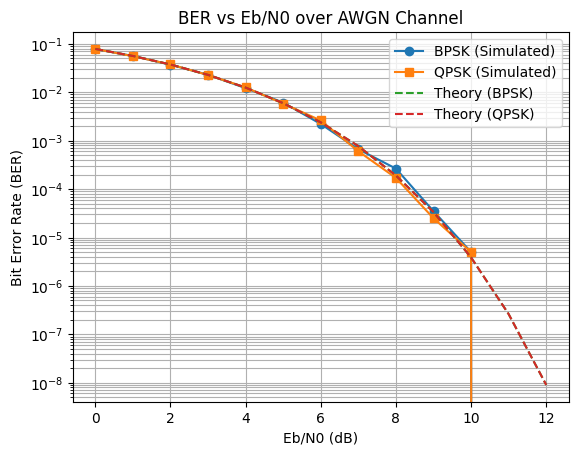

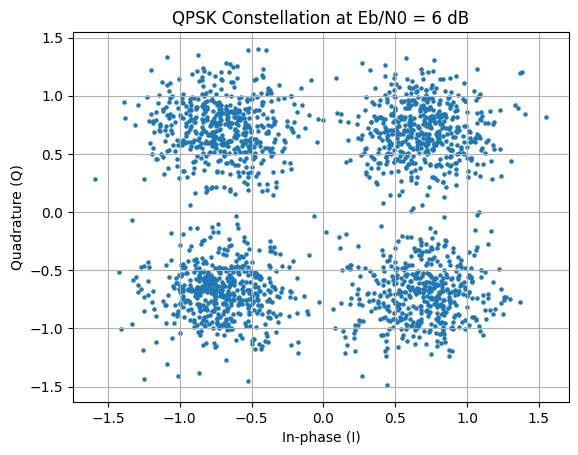

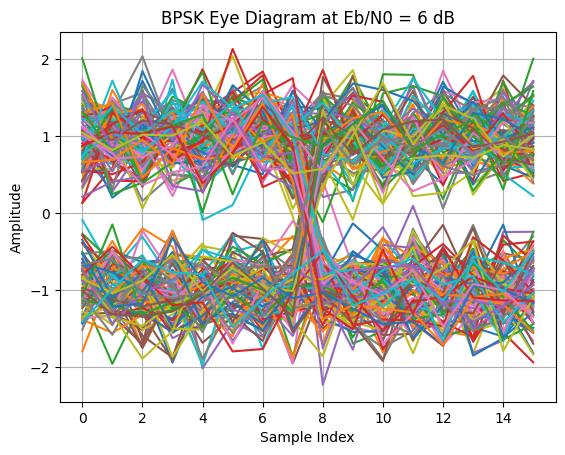

In [8]:
# ============================================================
# Main Execution
# ============================================================

def main():

    ebn0_db_grid = np.arange(0, 13, 1)
    n_bits = 200_000

    ebn0_bpsk, ber_bpsk_sim, ber_bpsk_th = simulate_ber(
        "BPSK", n_bits, ebn0_db_grid, seed=1
    )

    ebn0_qpsk, ber_qpsk_sim, ber_qpsk_th = simulate_ber(
        "QPSK", n_bits, ebn0_db_grid, seed=2
    )

    plt.figure()
    plt.semilogy(ebn0_bpsk, ber_bpsk_sim, marker="o", label="BPSK (Simulated)")
    plt.semilogy(ebn0_qpsk, ber_qpsk_sim, marker="s", label="QPSK (Simulated)")
    plt.semilogy(ebn0_db_grid, ber_bpsk_th, linestyle="--", label="Theory (BPSK)")
    plt.semilogy(ebn0_db_grid, ber_qpsk_th, linestyle="--", label="Theory (QPSK)")

    plt.xlabel("Eb/N0 (dB)")
    plt.ylabel("Bit Error Rate (BER)")
    plt.title("BER vs Eb/N0 over AWGN Channel")
    plt.grid(True, which="both")
    plt.legend()
    plt.show()

    # Constellation visualization
    rng = np.random.default_rng(123)
    bits = rng.integers(0, 2, size=50_000, dtype=np.int32)
    tx_qpsk = qpsk_mod_gray(bits)
    rx_qpsk = add_awgn_by_ebn0(tx_qpsk, 6.0, bits_per_symbol=2, rng=rng)
    plot_constellation(rx_qpsk, "QPSK Constellation at Eb/N0 = 6 dB")

    # Eye diagram visualization
    sps = 8
    bits_eye = rng.integers(0, 2, size=4000, dtype=np.int32)
    sym_eye = bpsk_mod(bits_eye).astype(np.float64)
    wave = make_rectangular_waveform(sym_eye, sps)
    rx_wave = add_awgn_by_ebn0(wave, 6.0, bits_per_symbol=1, rng=rng)
    plot_eye_diagram(rx_wave, sps, title="BPSK Eye Diagram at Eb/N0 = 6 dB")


if __name__ == "__main__":
    main()
